In [1]:
import numpy as np
import cv2
import random
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/syrnik/miniconda3/envs/abbyy_ml/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


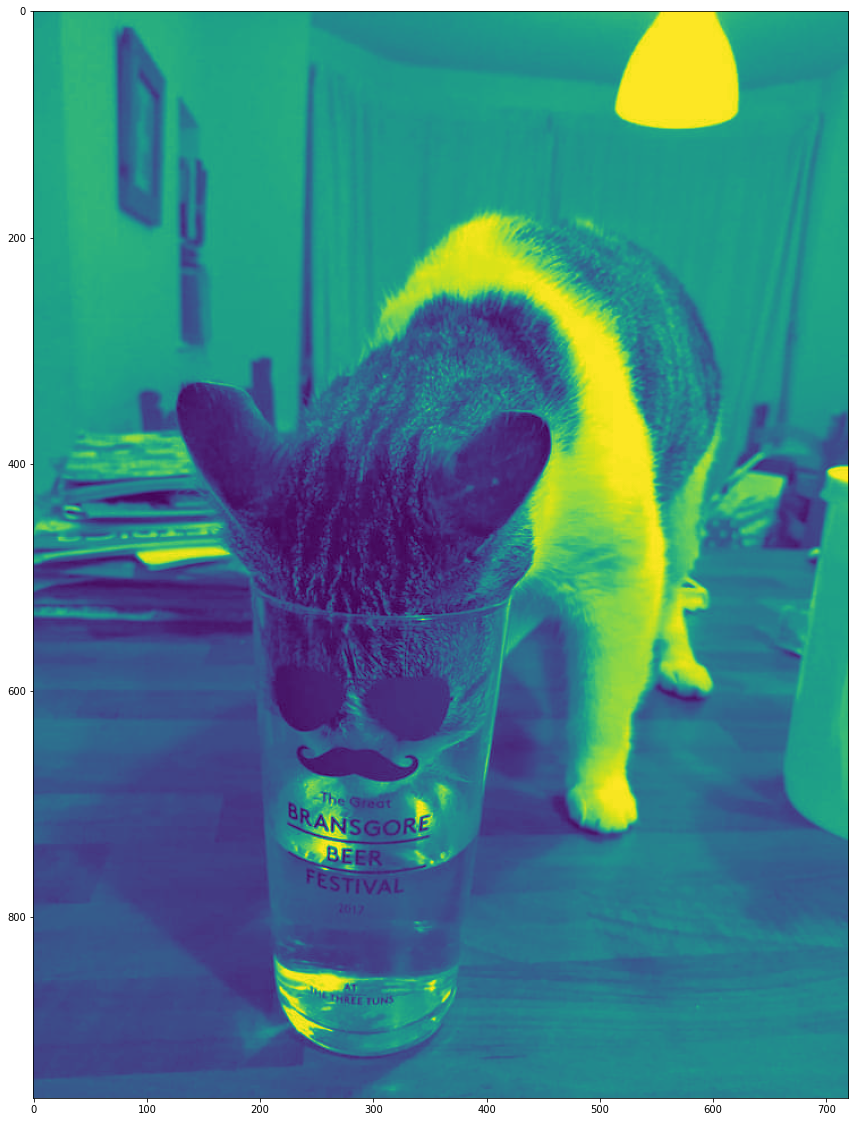

In [2]:
img = cv2.imread("cv2_test_img.jpeg", 0)
figure(figsize=(25, 20))
plt.imshow(img)
plt.show()

In [3]:
def salt_and_pepper(img):
    out = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rand_num = random.random()
            if rand_num < 0.05:
                out[i][j] = 0
            elif rand_num > 0.95:
                out[i][j] = 255
            else:
                out[i][j] = img[i][j]
    return out

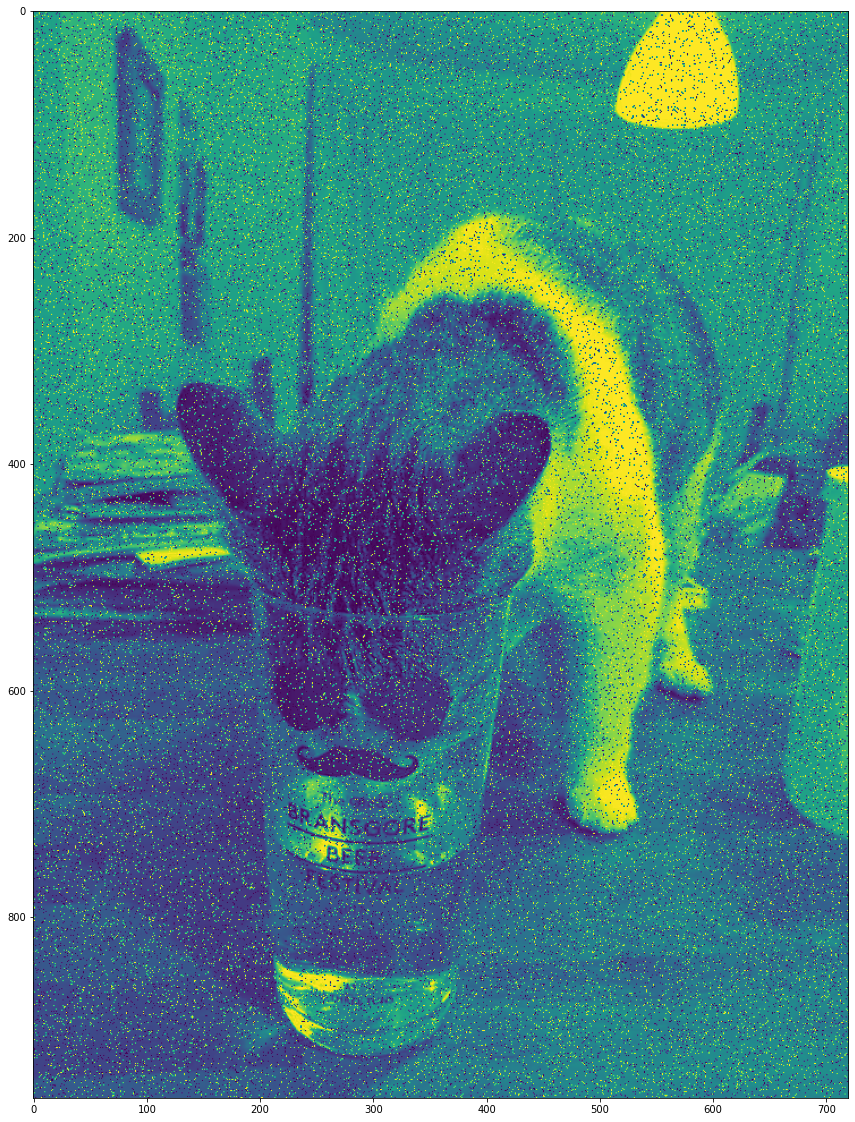

In [4]:
noisy_img = salt_and_pepper(img)
figure(figsize=(25, 20))
plt.imshow(noisy_img)
plt.show()

In [5]:
def simple_median_filter(img, filter_edge_size):
    out = list()
    border_size = filter_edge_size // 2
    img_with_border = np.zeros((img.shape[0] + 2*border_size , img.shape[1] + 2*border_size), np.uint8)
    img_with_border[border_size : img_with_border.shape[0] - border_size, 
                    border_size : img_with_border.shape[1] - border_size] = img
    for i in range(border_size, img_with_border.shape[0] - border_size):
        for j in range(border_size, img_with_border.shape[1] - border_size):
            pixels_in_filter = img_with_border[i - border_size : i + border_size + 1, 
                                               j - border_size : j + border_size + 1].flatten()
            # compute median
            median_value = np.sort(pixels_in_filter)[len(pixels_in_filter) // 2]
            out.append(median_value)
    out = np.array(out)
    return out.reshape(img.shape)

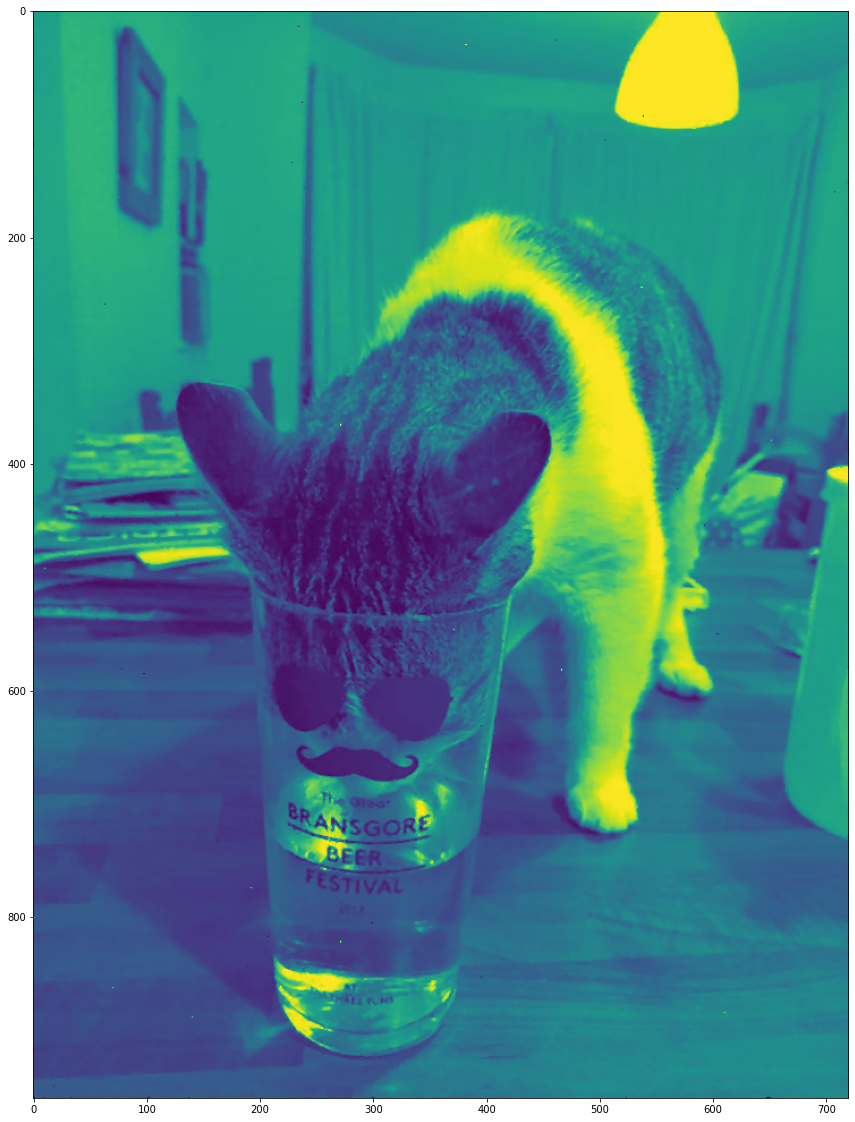

In [6]:
removed_noise = simple_median_filter(noisy_img, 3)
figure(figsize=(25, 20))
plt.imshow(removed_noise)
plt.show()

In [7]:
def huang_median_filter(img, filter_edge_size):
    out = list()
    border_size = filter_edge_size // 2
    full_filter_size = filter_edge_size ** 2
    img_with_border = np.zeros((img.shape[0] + 2*border_size , img.shape[1] + 2*border_size), np.uint8)
    img_with_border[border_size : img_with_border.shape[0] - border_size, 
                    border_size : img_with_border.shape[1] - border_size] = img

    for i in range(border_size, img_with_border.shape[0] - border_size):
        hist = np.zeros(256)
        median_value = -1
        count = 0
        prev_filter_left_column = np.array([])
        for j in range(border_size, img_with_border.shape[1] - border_size):
            # initialize hist on a new row
            if j == border_size:
                pixels_in_filter = img_with_border[i - border_size : i + border_size + 1, 
                                                   j - border_size : j + border_size + 1]
                prev_filter_left_column = pixels_in_filter[:, 0]
                for k in pixels_in_filter.flatten():
                    hist[k] += 1
                # compute median for a new hist
                for k in range(256):
                    if count + hist[k] > full_filter_size // 2:
                        median_value = k
                        break
                    count += hist[k]
            # update hist on a new column
            else:
                new_column = img_with_border[i - border_size : i + border_size + 1, j + border_size]
                for k in prev_filter_left_column:
                    hist[k] -= 1
                    if k < median_value:
                        count -= 1
                for k in new_column:
                    hist[k] += 1
                    if k < median_value:
                        count += 1
                prev_filter_left_column = img_with_border[i - border_size : i + border_size + 1, j - border_size]
                
                # compute median for a pixel
                if count > full_filter_size // 2:
                    while count > full_filter_size // 2:
                        median_value -= 1
                        count -= hist[median_value]
                else:
                    while count + hist[median_value] <= full_filter_size // 2:
                        count += hist[median_value]
                        median_value += 1

            out.append(median_value)

    out = np.array(out)
    return out.reshape(img.shape)

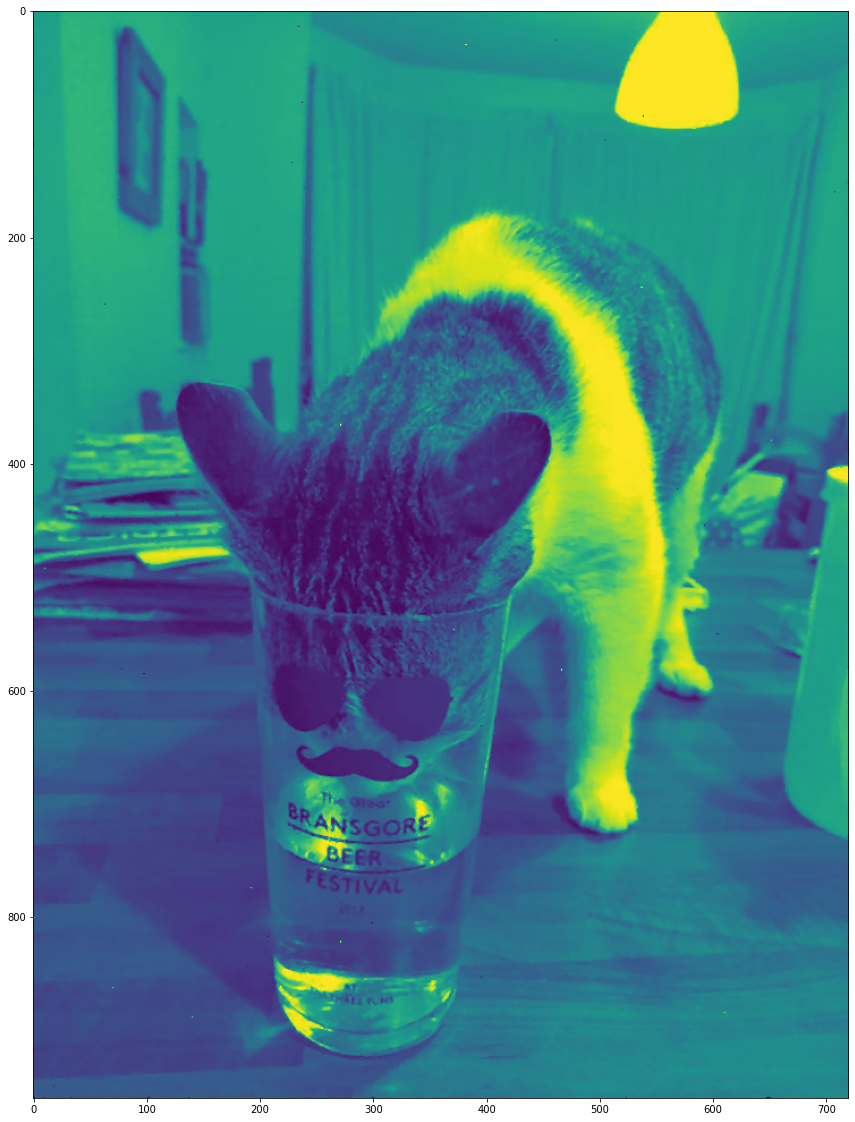

In [8]:
removed_noise = huang_median_filter(noisy_img, 3) 
figure(figsize=(25, 20))
plt.imshow(removed_noise)
plt.show()

In [9]:
def constant_time_median_filter(img, filter_edge_size):
    out = list()
    border_size = filter_edge_size // 2
    full_filter_size = filter_edge_size ** 2
    img_with_border = np.zeros((img.shape[0] + 2*border_size , img.shape[1] + 2*border_size), np.uint8)
    img_with_border[border_size : img_with_border.shape[0] - border_size, 
                    border_size : img_with_border.shape[1] - border_size] = img

    # compute list of hists for first row
    list_of_hists_columns = list()
    i = border_size
    for j in range(img_with_border.shape[1]):
        curr_column = img_with_border[i - border_size : i + border_size + 1, j]
        tmp_hist = np.zeros(256)
        for k in curr_column:
            tmp_hist[k] += 1
          
        list_of_hists_columns.append(tmp_hist)
    
    for i in range(border_size, img_with_border.shape[0] - border_size):
        hist_of_pixels_in_filter = np.zeros(256)
        median_value = -1
        count = 0
        prev_left_hist_column = np.zeros(256)
        for j in range(border_size, img_with_border.shape[1] - border_size):
            # initialize hist on a new row
            if j == border_size:
                # update hist for next row
                if i != border_size:
                    pixels_to_delete = img_with_border[i - border_size - 1, j - border_size : j + border_size + 1]
                    pixels_to_add = img_with_border[i + border_size, j - border_size : j + border_size + 1]
                    for k in range(2*border_size + 1):
                        list_of_hists_columns[k][pixels_to_delete[k]] -= 1
                        list_of_hists_columns[k][pixels_to_add[k]] += 1
                        
                for k in range(2*border_size + 1):
                    hist_of_pixels_in_filter += list_of_hists_columns[k]

                prev_left_hist_column = list_of_hists_columns[0]
                # compute median for a new hist
                for k in range(256):
                    if count + hist_of_pixels_in_filter[k] > full_filter_size // 2:
                        median_value = k
                        break
                    count += hist_of_pixels_in_filter[k]
            # update hist on a new column
            else:
                # update new hist column for next row
                if i != border_size:
                    list_of_hists_columns[j + border_size][img_with_border[i - border_size - 1][j + border_size]] -= 1
                    list_of_hists_columns[j + border_size][img_with_border[i + border_size][j + border_size]] += 1
                new_hist_column = list_of_hists_columns[j + border_size]

                count -= np.sum(prev_left_hist_column[:median_value])
                hist_of_pixels_in_filter -= prev_left_hist_column
                count += np.sum(new_hist_column[:median_value])
                hist_of_pixels_in_filter += new_hist_column

                prev_left_hist_column = list_of_hists_columns[j - border_size]
                
                # compute median for a pixel
                if count > full_filter_size // 2:
                    while count > full_filter_size // 2:
                        median_value -= 1
                        count -= hist_of_pixels_in_filter[median_value]
                else:
                    while count + hist_of_pixels_in_filter[median_value] <= full_filter_size // 2:
                        count += hist_of_pixels_in_filter[median_value]
                        median_value += 1
                
            out.append(median_value)

    out = np.array(out)
    return out.reshape(img.shape)

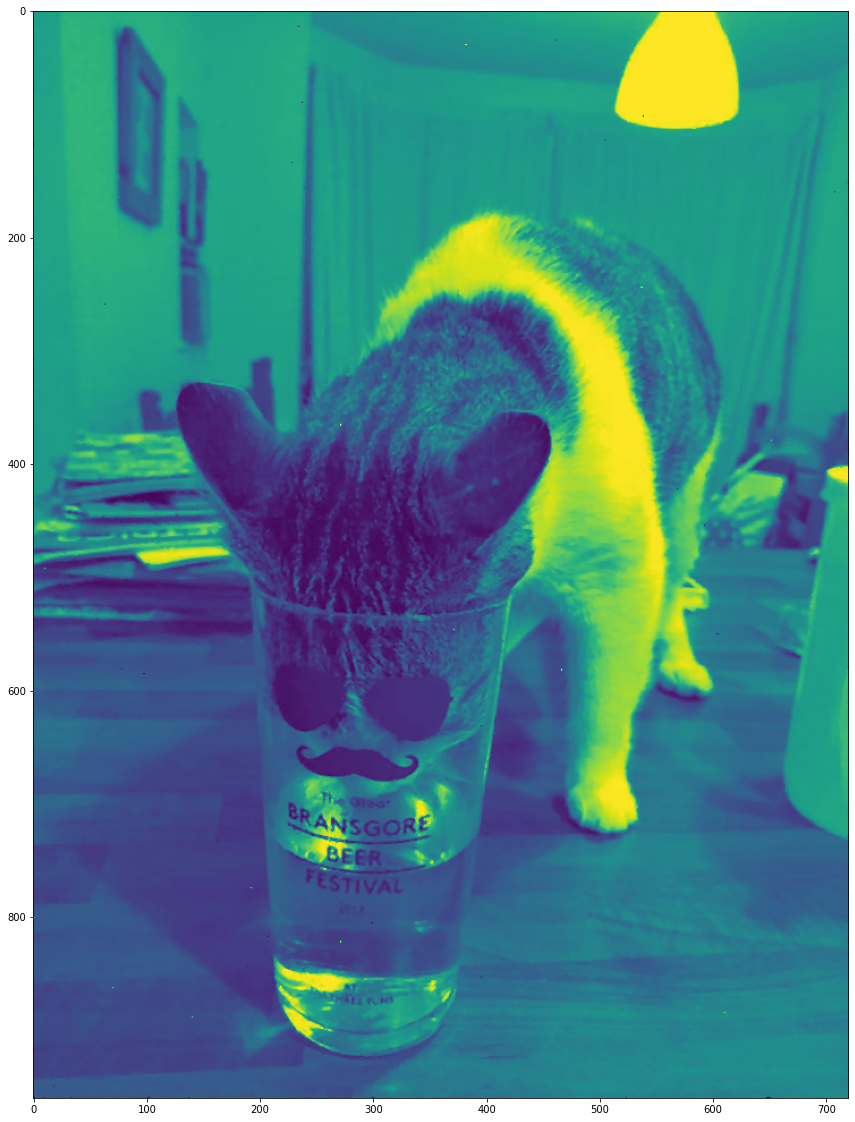

In [45]:
removed_noise = constant_time_median_filter(noisy_img, 3) 
figure(figsize=(25, 20))
plt.imshow(removed_noise)
plt.show()

In [11]:
removed_noise1 = simple_median_filter(noisy_img, 3) 
removed_noise2 = huang_median_filter(noisy_img, 3) 
removed_noise3 = constant_time_median_filter(noisy_img, 3)

In [12]:
print(np.sum(removed_noise1 - removed_noise2))
print(np.sum(removed_noise2 - removed_noise3))

0
0


Как мы видиим, результаты работы всех трех алгоритмов - ождинаковые.

Замерим скорость работы алгоритмов с разными знаяениями filter_edge_size

In [25]:
import timeit
from tqdm import tqdm 
simple_algo_time = []
huang_algo_time = []
const_algo_time = []

In [26]:
for filter_edge_size in tqdm(range(3, 100, 2)):
    for algo_indx in [1, 2, 3]:
        start = timeit.default_timer()
        
        if algo_indx == 1:
            simple_median_filter(noisy_img, filter_edge_size) 
        if algo_indx == 2:
            huang_median_filter(noisy_img, filter_edge_size) 
        if algo_indx == 3:
            constant_time_median_filter(noisy_img, filter_edge_size)

        stop = timeit.default_timer()
        
        if algo_indx == 1:
            simple_algo_time.append(stop - start)
        if algo_indx == 2:
            huang_algo_time.append(stop - start)
        if algo_indx == 3:
            const_algo_time.append(stop - start)

100%|██████████| 49/49 [3:05:08<00:00, 226.71s/it]  


In [61]:
img_size_in_pixels = img.size / 1000000
simple_algo_speed = [img_size_in_pixels / x for x in simple_algo_time]
huang_algo_speed = [img_size_in_pixels / x for x in huang_algo_time]
const_algo_speed = [img_size_in_pixels / x for x in const_algo_time]

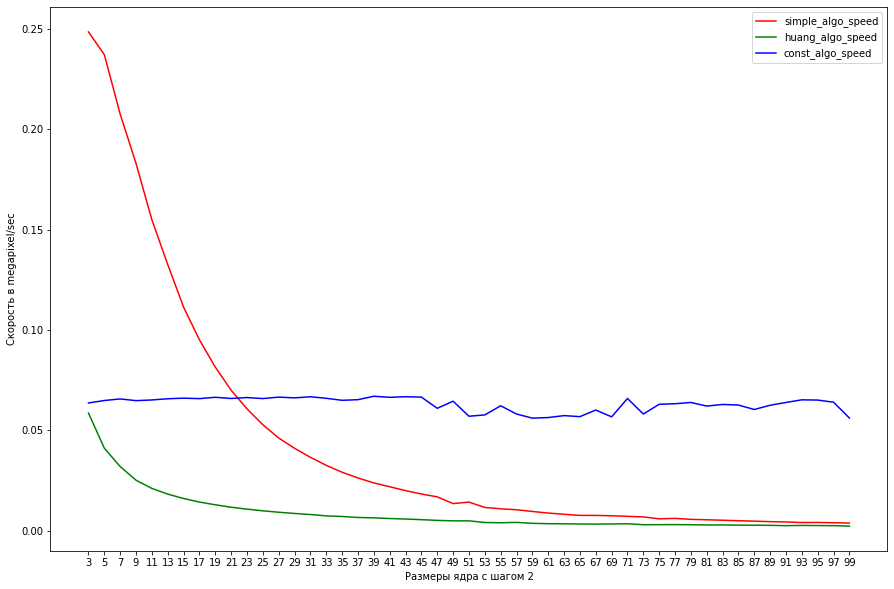

In [73]:
figure(figsize=(15, 10))
plt.plot(simple_algo_speed, color='red', label='simple_algo_speed')
plt.plot(huang_algo_speed, color='green', label='huang_algo_speed')
plt.plot(const_algo_speed, color='blue', label='const_algo_speed')
plt.legend()
plt.xticks(range(0, 49, 1), range(3, 100, 2))
plt.xlabel("Размеры ядра с шагом 2")
plt.ylabel("Скорость в megapixel/sec")
plt.show()

Как можно видеть оптимально использовать простой алгоритм для filter_edge_size < 23. Для filter_edge_size => 23 нужно использовать константный алгоритм

Оценивая практическую сложность:

простой алгоритм должен работать за O(N*M * k*logk), где N и M - размеры картинки, а k - количество пикселей в фильтре

алгоритм Huang'а должен работать за O(N*M * (2*(2*filter_edge_size + 1) + 255)), где 255 - максимальное число шагов, которые может сделать алгоритм подбора медианы

константный алгоритм(модификация алгоритма Huang'а) должен делать препроцессинг(подсчитываем гистограммы для первой строчки) за O(M*(2*filter_edge_size + 1)) и работать такой алгоритм будет за O(N*M * (2 * 255)), где 2 - количество операция для сдвига столбца гистограммы на один пиксель вниз, а 255 - максимальное число шагов, которые может сделать алгоритм подбора медианы